# Random Forest - Classificação de Comportamento de Bezerros

Este notebook implementa uma Random Forest simples para classificação de comportamentos de bezerros usando os dados do AcTBeCalf.

**Divisão dos dados:**
- Treino: 24 bezerros específicos
- Validação: 2 bezerros específicos  
- Teste: 4 bezerros específicos

In [20]:
# Imports necessários
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import polars as pl

print("Bibliotecas importadas com sucesso!")

Bibliotecas importadas com sucesso!


## 1. Carregamento e Preparação dos Dados

In [21]:
# Carregar dados
print("Carregando AcTBeCalf.parquet...")
df_pl = pl.read_parquet('AcTBeCalf.parquet')

# Converter para Pandas para facilitar manipulação
df = df_pl.to_pandas()

print(f"✅ Dados carregados: {len(df):,} amostras")
print(f"📊 Colunas: {list(df.columns)}")
print(f"🐄 Bezerros únicos: {df['calfId'].nunique()}")
print(f"📋 Comportamentos únicos: {df['behaviour'].nunique()}")

# Divisão específica de bezerros conforme solicitado
train_calves = ['1302', '1303', '1306', '1308', '1312', '1314', '1328', '1329',
                '1335', '1336', '1343', '1353', '1357', '1372', '1398', '1408',
                '1409', '1416', '1433', '1443', '1444', '1449', '1452', '1455']

val_calves = ['1320', '1405']

test_calves = ['1319', '1333', '1351', '1403']

print(f"\n📊 Divisão de bezerros:")
print(f"  Treino: {len(train_calves)} bezerros")
print(f"  Validação: {len(val_calves)} bezerros")
print(f"  Teste: {len(test_calves)} bezerros")

# Verificar se todos os bezerros existem nos dados
all_calves = set(train_calves + val_calves + test_calves)
existing_calves = set(df['calfId'].unique())
missing_calves = all_calves - existing_calves

Carregando AcTBeCalf.parquet...
✅ Dados carregados: 2,467,162 amostras
📊 Colunas: ['dateTime', 'calfId', 'accX', 'accY', 'accZ', 'behaviour', 'segId']
🐄 Bezerros únicos: 30
📋 Comportamentos únicos: 50

📊 Divisão de bezerros:
  Treino: 24 bezerros
  Validação: 2 bezerros
  Teste: 4 bezerros
🐄 Bezerros únicos: 30
📋 Comportamentos únicos: 50

📊 Divisão de bezerros:
  Treino: 24 bezerros
  Validação: 2 bezerros
  Teste: 4 bezerros


In [22]:
# Identificar e filtrar as 8 classes com mais amostras
print("🔍 Identificando as 8 classes com mais amostras...")
print("=" * 60)

# Contar amostras por classe no dataset completo
class_counts = df['behaviour'].value_counts()
print(f"\n📊 Total de classes no dataset: {len(class_counts)}")
print(f"\n🔝 Top 10 classes por quantidade:")
for i, (behavior, count) in enumerate(class_counts.head(10).items(), 1):
    print(f"  {i}. {behavior}: {count:,} amostras ({count/len(df)*100:.2f}%)")

# Selecionar as 8 classes com mais amostras
top_8_classes = class_counts.head(8).index.tolist()

print(f"\n✅ 8 classes selecionadas:")
for i, behavior in enumerate(top_8_classes, 1):
    count = class_counts[behavior]
    print(f"  {i}. {behavior}: {count:,} amostras ({count/len(df)*100:.2f}%)")

# Filtrar dataset para conter apenas as 8 classes
print(f"\n📉 Filtrando dataset...")
df_original_size = len(df)
df = df[df['behaviour'].isin(top_8_classes)].copy()

print(f"  Original: {df_original_size:,} amostras")
print(f"  Filtrado (8 classes): {len(df):,} amostras")
print(f"  Redução: {(1 - len(df)/df_original_size)*100:.2f}%")

print(f"\n✅ Dataset atualizado com apenas as 8 classes principais!")

🔍 Identificando as 8 classes com mais amostras...

📊 Total de classes no dataset: 50

🔝 Top 10 classes por quantidade:
  1. lying: 965,184 amostras (39.12%)
  2. drinking_milk: 217,075 amostras (8.80%)
  3. standing: 188,908 amostras (7.66%)
  4. eating_concentrates: 146,067 amostras (5.92%)
  5. sniff: 134,768 amostras (5.46%)
  6. eating_bedding: 129,119 amostras (5.23%)
  7. oral_manipulation_of_pen: 118,210 amostras (4.79%)
  8. grooming: 114,181 amostras (4.63%)
  9. running: 83,345 amostras (3.38%)
  10. eating_forage: 80,428 amostras (3.26%)

✅ 8 classes selecionadas:
  1. lying: 965,184 amostras (39.12%)
  2. drinking_milk: 217,075 amostras (8.80%)
  3. standing: 188,908 amostras (7.66%)
  4. eating_concentrates: 146,067 amostras (5.92%)
  5. sniff: 134,768 amostras (5.46%)
  6. eating_bedding: 129,119 amostras (5.23%)
  7. oral_manipulation_of_pen: 118,210 amostras (4.79%)
  8. grooming: 114,181 amostras (4.63%)

📉 Filtrando dataset...
  Original: 2,467,162 amostras
  Filtrado

In [23]:
# Preparar features e labels
# Usar apenas as colunas de aceleração como features
feature_columns = ['accX', 'accY', 'accZ']
X = df[feature_columns].values
y = df['behaviour'].values

# Criar mapeamento de labels para inteiros
unique_labels = sorted(df['behaviour'].unique())
label_to_int = {label: i for i, label in enumerate(unique_labels)}
int_to_label = {i: label for label, i in label_to_int.items()}

y_encoded = np.array([label_to_int[label] for label in y])

print(f"📊 Shape das features: {X.shape}")
print(f"📋 Número de classes: {len(unique_labels)}")
print(f"🏷️ Classes: {unique_labels[:10]}...")  # Mostrar primeiras 10

# Criar divisões baseadas nos bezerros
train_mask = df['calfId'].isin(train_calves)
val_mask = df['calfId'].isin(val_calves)
test_mask = df['calfId'].isin(test_calves)

X_train = X[train_mask]
y_train = y_encoded[train_mask]

X_val = X[val_mask]
y_val = y_encoded[val_mask]

X_test = X[test_mask]
y_test = y_encoded[test_mask]

print(f"\n📊 Tamanho dos conjuntos:")
print(f"  Treino: {X_train.shape[0]:,} amostras")
print(f"  Validação: {X_val.shape[0]:,} amostras")
print(f"  Teste: {X_test.shape[0]:,} amostras")

📊 Shape das features: (2013512, 3)
📋 Número de classes: 8
🏷️ Classes: ['drinking_milk', 'eating_bedding', 'eating_concentrates', 'grooming', 'lying', 'oral_manipulation_of_pen', 'sniff', 'standing']...

📊 Tamanho dos conjuntos:
  Treino: 1,489,445 amostras
  Validação: 187,810 amostras
  Teste: 336,257 amostras


In [24]:
# Salvar os dados divididos em parquet
print("Salvando dados em parquet...")

# Criar DataFrames para cada conjunto
train_df = pd.DataFrame(X_train, columns=feature_columns)
train_df['behaviour'] = [int_to_label[i] for i in y_train]
train_df['label'] = y_train

val_df = pd.DataFrame(X_val, columns=feature_columns)
val_df['behaviour'] = [int_to_label[i] for i in y_val]
val_df['label'] = y_val

test_df = pd.DataFrame(X_test, columns=feature_columns)
test_df['behaviour'] = [int_to_label[i] for i in y_test]
test_df['label'] = y_test

# Salvar em parquet
train_df.to_parquet('train_data.parquet', index=False)
val_df.to_parquet('val_data.parquet', index=False)
test_df.to_parquet('test_data.parquet', index=False)

print("✅ Dados salvos com sucesso!")
print(f"  📁 train_data.parquet: {len(train_df):,} amostras")
print(f"  📁 val_data.parquet: {len(val_df):,} amostras")
print(f"  📁 test_data.parquet: {len(test_df):,} amostras")

Salvando dados em parquet...
✅ Dados salvos com sucesso!
  📁 train_data.parquet: 1,489,445 amostras
  📁 val_data.parquet: 187,810 amostras
  📁 test_data.parquet: 336,257 amostras
✅ Dados salvos com sucesso!
  📁 train_data.parquet: 1,489,445 amostras
  📁 val_data.parquet: 187,810 amostras
  📁 test_data.parquet: 336,257 amostras


## 2. Carregamento dos Dados Divididos e Random Forest

In [25]:
# Carregar dados dos parquets
print("Carregando dados salvos...")

train_p = pl.read_parquet('train_data.parquet')
val_p = pl.read_parquet('val_data.parquet')
test_p = pl.read_parquet('test_data.parquet')

train_data = train_p.to_pandas()
val_data = val_p.to_pandas()
test_data = test_p.to_pandas()

print(f"✅ Dados carregados:")
print(f"  📊 Treino: {len(train_data):,} amostras")
print(f"  📊 Validação: {len(val_data):,} amostras")
print(f"  📊 Teste: {len(test_data):,} amostras")

# Separar features e labels
feature_cols = ['accX', 'accY', 'accZ']

X_train_loaded = train_data[feature_cols].values
y_train_loaded = train_data['label'].values

X_val_loaded = val_data[feature_cols].values
y_val_loaded = val_data['label'].values

X_test_loaded = test_data[feature_cols].values
y_test_loaded = test_data['label'].values

print(f"\n📊 Shapes:")
print(f"  X_train: {X_train_loaded.shape}")
print(f"  X_val: {X_val_loaded.shape}")
print(f"  X_test: {X_test_loaded.shape}")

# Mostrar distribuição de classes
print(f"\n📋 Distribuição de classes no treino:")
unique, counts = np.unique(y_train_loaded, return_counts=True)
for label_idx, count in zip(unique, counts):
    behavior = train_data[train_data['label'] == label_idx]['behaviour'].iloc[0]
    print(f"  {behavior}: {count:,} amostras ({count/len(y_train_loaded)*100:.1f}%)")

Carregando dados salvos...
✅ Dados carregados:
  📊 Treino: 1,489,445 amostras
  📊 Validação: 187,810 amostras
  📊 Teste: 336,257 amostras

📊 Shapes:
  X_train: (1489445, 3)
  X_val: (187810, 3)
  X_test: (336257, 3)

📋 Distribuição de classes no treino:
  drinking_milk: 182,418 amostras (12.2%)
  eating_bedding: 97,120 amostras (6.5%)
  eating_concentrates: 112,273 amostras (7.5%)
  grooming: 99,363 amostras (6.7%)
  lying: 641,675 amostras (43.1%)
  oral_manipulation_of_pen: 93,386 amostras (6.3%)
  sniff: 111,078 amostras (7.5%)
  standing: 152,132 amostras (10.2%)
  lying: 641,675 amostras (43.1%)
  oral_manipulation_of_pen: 93,386 amostras (6.3%)
  sniff: 111,078 amostras (7.5%)
  standing: 152,132 amostras (10.2%)


In [26]:
# Treinar Random Forest
print("Treinando Random Forest...")

# Configuração simples da Random Forest
rf_classifier = RandomForestClassifier(
    n_estimators=100,
    max_depth=14,
    min_samples_leaf=200,
    random_state=42,
    n_jobs=4
)

# Treinar o modelo
rf_classifier.fit(X_train_loaded, y_train_loaded)

print("✅ Modelo treinado com sucesso!")

# Fazer predições
print("\nFazendo predições...")
y_train_pred = rf_classifier.predict(X_train_loaded)
y_val_pred = rf_classifier.predict(X_val_loaded)
y_test_pred = rf_classifier.predict(X_test_loaded)

# Calcular acurácias
train_accuracy = accuracy_score(y_train_loaded, y_train_pred)
val_accuracy = accuracy_score(y_val_loaded, y_val_pred)
test_accuracy = accuracy_score(y_test_loaded, y_test_pred)

print(f"\n🎯 Resultados:")
print(f"  Acurácia Treino: {train_accuracy:.4f} ({train_accuracy*100:.2f}%)")
print(f"  Acurácia Validação: {val_accuracy:.4f} ({val_accuracy*100:.2f}%)")
print(f"  Acurácia Teste: {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")

Treinando Random Forest...
✅ Modelo treinado com sucesso!

Fazendo predições...
✅ Modelo treinado com sucesso!

Fazendo predições...

🎯 Resultados:
  Acurácia Treino: 0.6338 (63.38%)
  Acurácia Validação: 0.1322 (13.22%)
  Acurácia Teste: 0.6856 (68.56%)

🎯 Resultados:
  Acurácia Treino: 0.6338 (63.38%)
  Acurácia Validação: 0.1322 (13.22%)
  Acurácia Teste: 0.6856 (68.56%)


## 3. Avaliação Detalhada

In [27]:
# Relatório de classificação para conjunto de teste
print("📊 RELATÓRIO DE CLASSIFICAÇÃO - CONJUNTO DE TESTE")
print("=" * 60)

# Obter nomes dos comportamentos para o relatório
behavior_names = []
for label_idx in sorted(np.unique(y_test_loaded)):
    behavior = test_data[test_data['label'] == label_idx]['behaviour'].iloc[0]
    behavior_names.append(behavior)

behavior_names

# Relatório detalhado
report = classification_report(
    y_test_loaded,
    y_test_pred,
    target_names=behavior_names,
    digits=4
)
print(report)

# Importância das features
print(f"\n🔍 IMPORTÂNCIA DAS FEATURES:")
print("=" * 40)
feature_importance = rf_classifier.feature_importances_
for i, feature in enumerate(feature_cols):
    print(f"  {feature}: {feature_importance[i]:.4f}")

print(f"\n📈 RESUMO FINAL:")
print("=" * 30)
print(f"  🎯 Acurácia Final (Teste): {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")
print(f"  🌲 Número de árvores: {rf_classifier.n_estimators}")
print(f"  📊 Total de amostras teste: {len(y_test_loaded):,}")
print(f"  📋 Total de classes: {len(behavior_names)}")

📊 RELATÓRIO DE CLASSIFICAÇÃO - CONJUNTO DE TESTE
                          precision    recall  f1-score   support

           drinking_milk     0.5409    0.6497    0.5903     21066
          eating_bedding     0.0097    0.0040    0.0057     25964
     eating_concentrates     0.0075    0.0280    0.0119      3146
                grooming     0.0552    0.0915    0.0689      4591
                   lying     0.8667    0.8557    0.8612    245131
oral_manipulation_of_pen     0.0183    0.0148    0.0164     10388
                   sniff     0.2200    0.2793    0.2461     13421
                standing     0.1911    0.2050    0.1978     12550

                accuracy                         0.6856    336257
               macro avg     0.2387    0.2660    0.2498    336257
            weighted avg     0.6838    0.6856    0.6840    336257


🔍 IMPORTÂNCIA DAS FEATURES:
  accX: 0.2945
  accY: 0.3875
  accZ: 0.3180

📈 RESUMO FINAL:
  🎯 Acurácia Final (Teste): 0.6856 (68.56%)
  🌲 Número de árvores

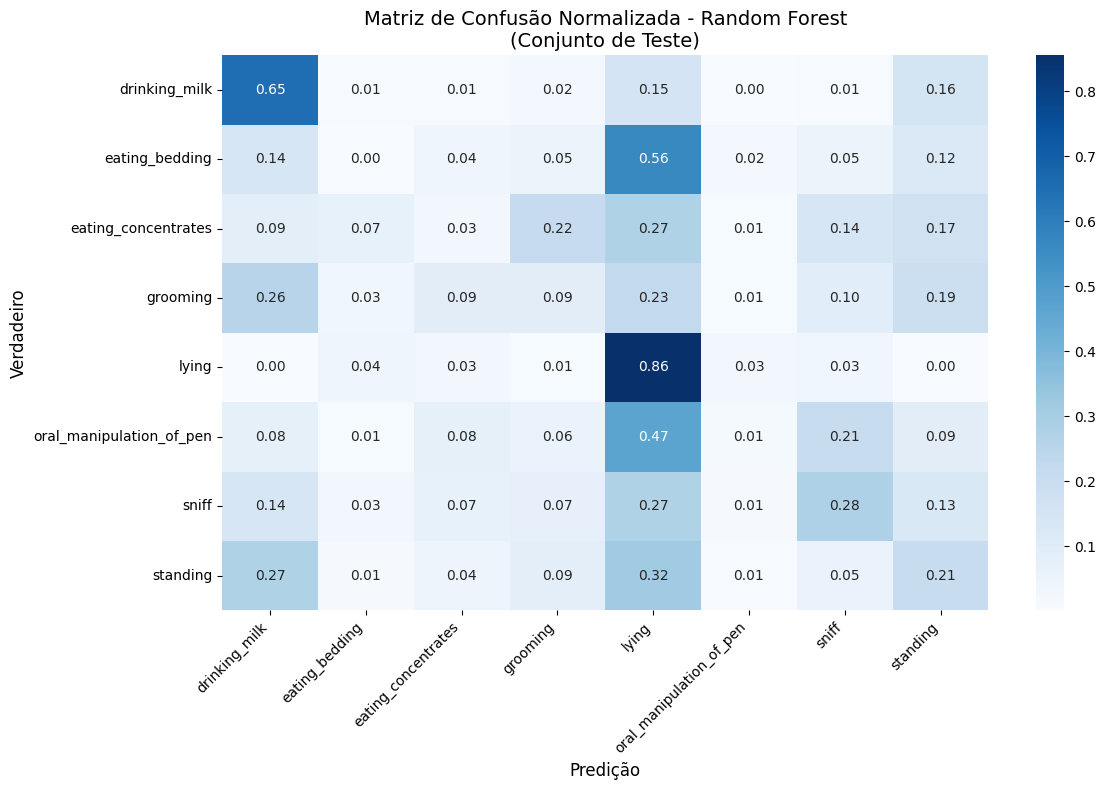

📊 Matriz de Confusão Normalizada gerada para 8 classes


In [32]:
# Matriz de confusão normalizada
plt.figure(figsize=(12, 8))

# Calcular matriz de confusão normalizada
cm_normalized = confusion_matrix(y_test_loaded, y_test_pred, normalize='true')

# Plotar matriz de confusão normalizada
sns.heatmap(cm_normalized,
           annot=True,
           fmt='.2f',
           cmap='Blues',
           xticklabels=behavior_names,
           yticklabels=behavior_names)

plt.title('Matriz de Confusão Normalizada - Random Forest\n(Conjunto de Teste)', fontsize=14)
plt.xlabel('Predição', fontsize=12)
plt.ylabel('Verdadeiro', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

print(f"📊 Matriz de Confusão Normalizada gerada para {len(behavior_names)} classes")

## 4. Avaliação do Conjunto de Validação

In [33]:
# Relatório de classificação para conjunto de validação
print("📊 RELATÓRIO DE CLASSIFICAÇÃO - CONJUNTO DE VALIDAÇÃO")
print("=" * 60)

# Obter nomes dos comportamentos para o relatório
behavior_names_val = []
for label_idx in sorted(np.unique(y_val_loaded)):
    behavior = val_data[val_data['label'] == label_idx]['behaviour'].iloc[0]
    behavior_names_val.append(behavior)

# Relatório detalhado
report_val = classification_report(
    y_val_loaded,
    y_val_pred,
    target_names=behavior_names_val,
    digits=4
)
print(report_val)

print(f"\n📈 RESUMO DO CONJUNTO DE VALIDAÇÃO:")
print("=" * 40)
print(f"  🎯 Acurácia: {val_accuracy:.4f} ({val_accuracy*100:.2f}%)")
print(f"  📊 Total de amostras: {len(y_val_loaded):,}")
print(f"  📋 Total de classes: {len(behavior_names_val)}")

# Distribuição de classes na validação
print(f"\n📋 Distribuição de classes no conjunto de validação:")
unique_val, counts_val = np.unique(y_val_loaded, return_counts=True)
for label_idx, count in zip(unique_val, counts_val):
    behavior = val_data[val_data['label'] == label_idx]['behaviour'].iloc[0]
    print(f"  {behavior}: {count:,} amostras ({count/len(y_val_loaded)*100:.1f}%)")

📊 RELATÓRIO DE CLASSIFICAÇÃO - CONJUNTO DE VALIDAÇÃO
                          precision    recall  f1-score   support

           drinking_milk     0.0989    0.3655    0.1557     13591
          eating_bedding     0.0490    0.0075    0.0129      6035
     eating_concentrates     0.1786    0.2006    0.1890     30648
                grooming     0.1935    0.1133    0.1429     10227
                   lying     0.2158    0.0979    0.1347     78378
oral_manipulation_of_pen     0.0960    0.0076    0.0140     14436
                   sniff     0.0650    0.3180    0.1079     10269
                standing     0.1558    0.0600    0.0866     24226

                accuracy                         0.1322    187810
               macro avg     0.1316    0.1463    0.1055    187810
            weighted avg     0.1695    0.1322    0.1247    187810


📈 RESUMO DO CONJUNTO DE VALIDAÇÃO:
  🎯 Acurácia: 0.1322 (13.22%)
  📊 Total de amostras: 187,810
  📋 Total de classes: 8

📋 Distribuição de classes no c

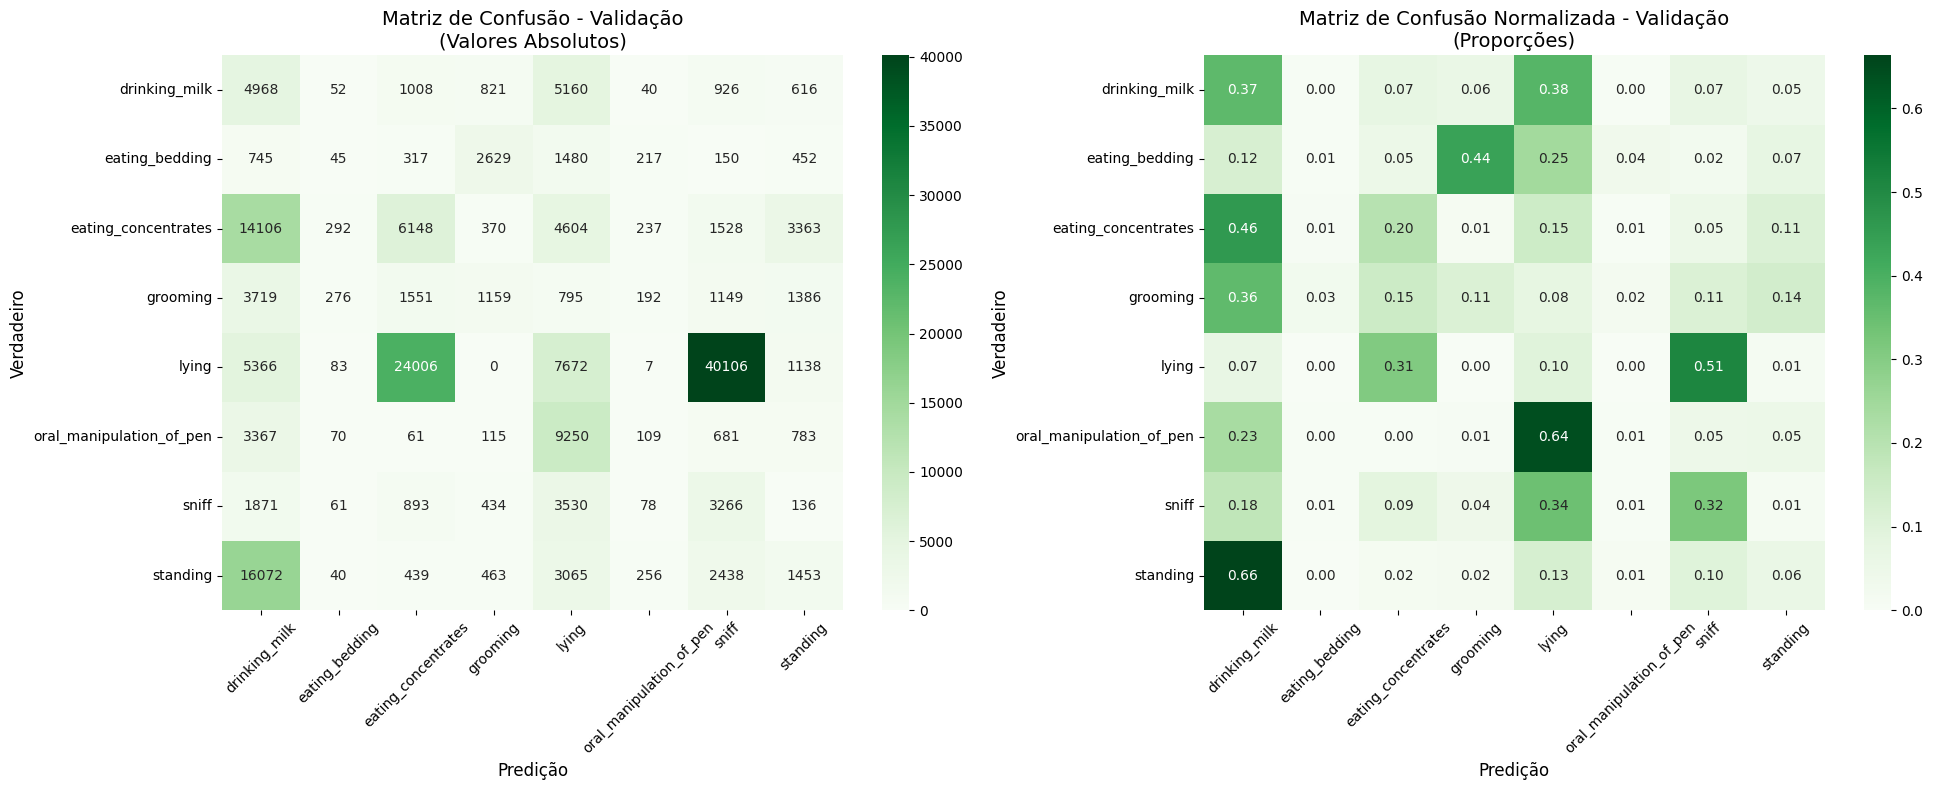

📊 Matrizes de Confusão geradas para o conjunto de validação (8 classes)


In [34]:
# Matriz de confusão para conjunto de validação
fig, axes = plt.subplots(1, 2, figsize=(20, 8))

# Matriz de confusão absoluta
cm_val = confusion_matrix(y_val_loaded, y_val_pred)
sns.heatmap(cm_val,
           annot=True,
           fmt='d',
           cmap='Greens',
           xticklabels=behavior_names_val,
           yticklabels=behavior_names_val,
           ax=axes[0])
axes[0].set_title('Matriz de Confusão - Validação\n(Valores Absolutos)', fontsize=14)
axes[0].set_xlabel('Predição', fontsize=12)
axes[0].set_ylabel('Verdadeiro', fontsize=12)
axes[0].tick_params(axis='x', rotation=45)

# Matriz de confusão normalizada
cm_val_normalized = confusion_matrix(y_val_loaded, y_val_pred, normalize='true')
sns.heatmap(cm_val_normalized,
           annot=True,
           fmt='.2f',
           cmap='Greens',
           xticklabels=behavior_names_val,
           yticklabels=behavior_names_val,
           ax=axes[1])
axes[1].set_title('Matriz de Confusão Normalizada - Validação\n(Proporções)', fontsize=14)
axes[1].set_xlabel('Predição', fontsize=12)
axes[1].set_ylabel('Verdadeiro', fontsize=12)
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

print(f"📊 Matrizes de Confusão geradas para o conjunto de validação ({len(behavior_names_val)} classes)")

📊 COMPARAÇÃO: TESTE vs VALIDAÇÃO
 Conjunto  Acurácia  Amostras  Classes
    Teste  0.685577    336257        8
Validação  0.132155    187810        8


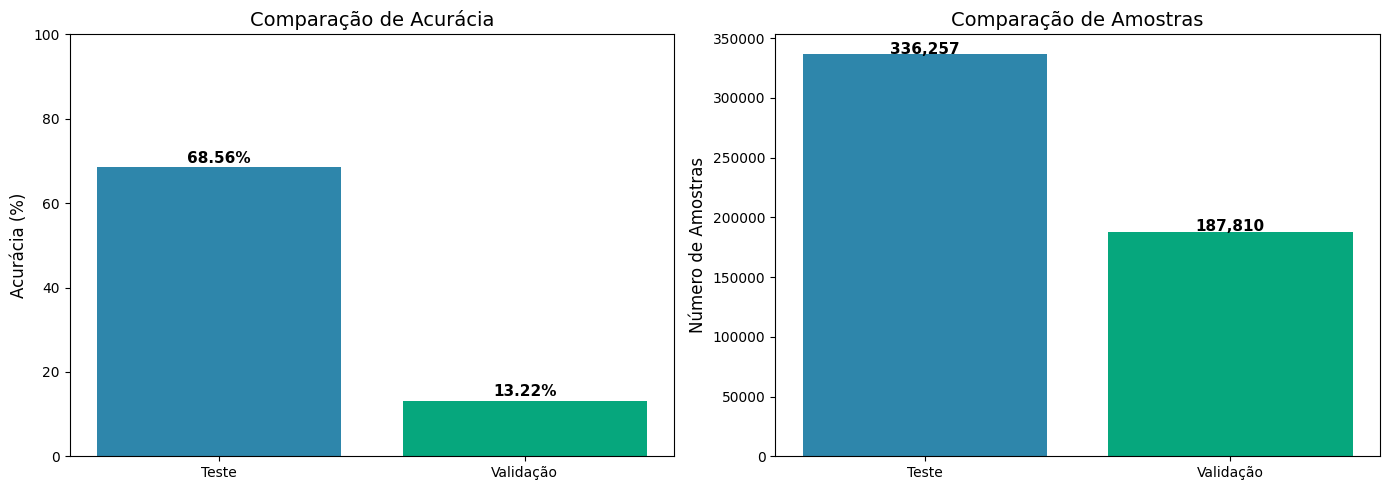


✅ Análise de validação concluída!
💡 Diferença de acurácia: 55.34%


In [ ]:
# Comparação entre Teste e Validação
print("📊 COMPARAÇÃO: TESTE vs VALIDAÇÃO")
print("=" * 60)

# Criar DataFrame de comparação
comparison_data = {
    'Conjunto': ['Teste', 'Validação'],
    'Acurácia': [test_accuracy, val_accuracy],
    'Amostras': [len(y_test_loaded), len(y_val_loaded)],
    'Classes': [len(behavior_names), len(behavior_names_val)]
}

comparison_df = pd.DataFrame(comparison_data)
print(comparison_df.to_string(index=False))

# Visualização da comparação
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Gráfico de barras - Acurácia
axes[0].bar(['Teste', 'Validação'],
           [test_accuracy*100, val_accuracy*100],
           color=['#2E86AB', '#06A77D'])
axes[0].set_ylabel('Acurácia (%)', fontsize=12)
axes[0].set_title('Comparação de Acurácia', fontsize=14)
axes[0].set_ylim([0, 100])
for i, v in enumerate([test_accuracy*100, val_accuracy*100]):
    axes[0].text(i, v + 1, f'{v:.2f}%', ha='center', fontsize=11, fontweight='bold')

# Gráfico de barras - Número de amostras
axes[1].bar(['Teste', 'Validação'],
           [len(y_test_loaded), len(y_val_loaded)],
           color=['#2E86AB', '#06A77D'])
axes[1].set_ylabel('Número de Amostras', fontsize=12)
axes[1].set_title('Comparação de Amostras', fontsize=14)
for i, v in enumerate([len(y_test_loaded), len(y_val_loaded)]):
    axes[1].text(i, v + 500, f'{v:,}', ha='center', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.show()

print(f"\n✅ Análise de validação concluída!")
print(f"💡 Diferença de acurácia: {abs(test_accuracy - val_accuracy)*100:.2f}%")

## 5. Salvar Predições em CSV

In [38]:
# Salvar predições do conjunto de TESTE em CSV
print("💾 Salvando predições do conjunto de TESTE...")

# Criar DataFrame com as predições
predictions_test_df = pd.DataFrame({
    'timestamp': range(len(y_test_loaded[:10000])),  # Índice sequencial como timestamp
    'real': [test_data[test_data['label'] == label]['behaviour'].iloc[0] for label in y_test_loaded[:10000]],
    'predito': [test_data[test_data['label'] == label]['behaviour'].iloc[0] for label in y_test_pred[:10000]]
})

# Adicionar coluna de acerto
predictions_test_df['acerto'] = predictions_test_df['real'] == predictions_test_df['predito']

# Salvar em CSV
predictions_test_df.to_csv('predicoes_teste.csv', index=False)

print(f"✅ Arquivo salvo: predicoes_teste.csv")
print(f"📊 Total de predições: {len(predictions_test_df):,}")
print(f"✔️ Acertos: {predictions_test_df['acerto'].sum():,} ({predictions_test_df['acerto'].sum()/len(predictions_test_df)*100:.2f}%)")
print(f"❌ Erros: {(~predictions_test_df['acerto']).sum():,} ({(~predictions_test_df['acerto']).sum()/len(predictions_test_df)*100:.2f}%)")

# Mostrar primeiras linhas
print(f"\n📋 Primeiras 10 linhas do arquivo:")
print(predictions_test_df.head(10).to_string(index=False))

💾 Salvando predições do conjunto de TESTE...
✅ Arquivo salvo: predicoes_teste.csv
📊 Total de predições: 10,000
✔️ Acertos: 4,074 (40.74%)
❌ Erros: 5,926 (59.26%)

📋 Primeiras 10 linhas do arquivo:
 timestamp                real predito  acerto
         0 eating_concentrates   sniff   False
         1 eating_concentrates   sniff   False
         2 eating_concentrates   sniff   False
         3 eating_concentrates   sniff   False
         4 eating_concentrates   sniff   False
         5 eating_concentrates   sniff   False
         6 eating_concentrates   sniff   False
         7 eating_concentrates   sniff   False
         8 eating_concentrates   sniff   False
         9 eating_concentrates   sniff   False
✅ Arquivo salvo: predicoes_teste.csv
📊 Total de predições: 10,000
✔️ Acertos: 4,074 (40.74%)
❌ Erros: 5,926 (59.26%)

📋 Primeiras 10 linhas do arquivo:
 timestamp                real predito  acerto
         0 eating_concentrates   sniff   False
         1 eating_concentrates   sniff  

In [ ]:
# Salvar predições do conjunto de VALIDAÇÃO em CSV
print("💾 Salvando predições do conjunto de VALIDAÇÃO...")

bl

# Criar DataFrame com as predições
predictions_val_df = pd.DataFrame({
    'timestamp': range(len(y_val_loaded)),  # Índice sequencial como timestamp
    'real': [val_data[val_data['label'] == label]['behaviour'].iloc[0] for label in y_val_loaded],
    'predito': [val_data[val_data['label'] == label]['behaviour'].iloc[0] for label in y_val_pred]
})

# Adicionar coluna de acerto
predictions_val_df['acerto'] = predictions_val_df['real'] == predictions_val_df['predito']

# Salvar em CSV
predictions_val_df.to_csv('predicoes_validacao.csv', index=False)

print(f"✅ Arquivo salvo: predicoes_validacao.csv")
print(f"📊 Total de predições: {len(predictions_val_df):,}")
print(f"✔️ Acertos: {predictions_val_df['acerto'].sum():,} ({predictions_val_df['acerto'].sum()/len(predictions_val_df)*100:.2f}%)")
print(f"❌ Erros: {(~predictions_val_df['acerto']).sum():,} ({(~predictions_val_df['acerto']).sum()/len(predictions_val_df)*100:.2f}%)")

# Mostrar primeiras linhas
print(f"\n📋 Primeiras 10 linhas do arquivo:")
print(predictions_val_df.head(10).to_string(index=False))

📊 ANÁLISE DE ERROS NAS PREDIÇÕES


NameError: name 'error_counts_val' is not defined

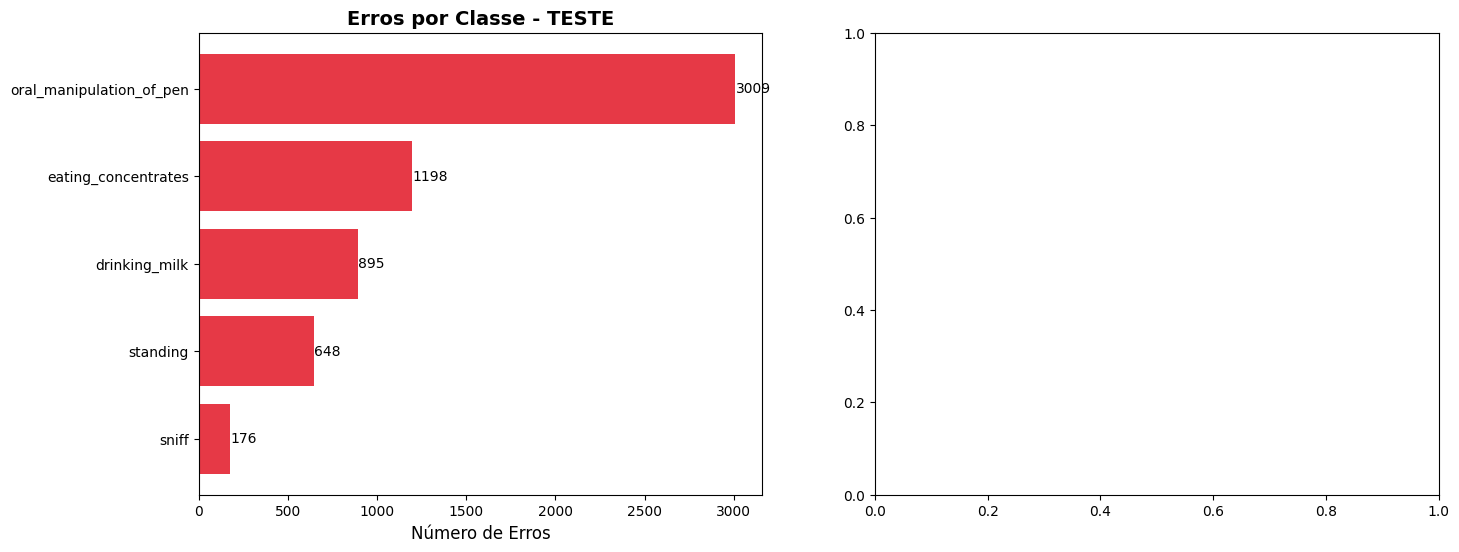

In [40]:
# Análise visual dos erros de predição
print("📊 ANÁLISE DE ERROS NAS PREDIÇÕES")
print("=" * 60)

# Contar erros por classe - TESTE
errors_test = predictions_test_df[~predictions_test_df['acerto']]
error_counts_test = errors_test['real'].value_counts()

# Visualização
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Gráfico de erros - TESTE
if len(error_counts_test) > 0:
    axes[0].barh(error_counts_test.index, error_counts_test.values, color='#E63946')
    axes[0].set_xlabel('Número de Erros', fontsize=12)
    axes[0].set_title('Erros por Classe - TESTE', fontsize=14, fontweight='bold')
    axes[0].invert_yaxis()
    for i, v in enumerate(error_counts_test.values):
        axes[0].text(v + 0.5, i, str(v), va='center', fontsize=10)
else:
    axes[0].text(0.5, 0.5, 'Nenhum erro encontrado!',
                ha='center', va='center', fontsize=14, transform=axes[0].transAxes)
    axes[0].set_title('Erros por Classe - TESTE', fontsize=14, fontweight='bold')

# Gráfico de erros - VALIDAÇÃO
if len(error_counts_val) > 0:
    axes[1].barh(error_counts_val.index, error_counts_val.values, color='#F77F00')
    axes[1].set_xlabel('Número de Erros', fontsize=12)
    axes[1].set_title('Erros por Classe - VALIDAÇÃO', fontsize=14, fontweight='bold')
    axes[1].invert_yaxis()
    for i, v in enumerate(error_counts_val.values):
        axes[1].text(v + 0.5, i, str(v), va='center', fontsize=10)
else:
    axes[1].text(0.5, 0.5, 'Nenhum erro encontrado!',
                ha='center', va='center', fontsize=14, transform=axes[1].transAxes)
    axes[1].set_title('Erros por Classe - VALIDAÇÃO', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

print(f"\n✅ Arquivos CSV criados com sucesso!")
print(f"   📁 predicoes_teste.csv - {len(predictions_test_df):,} linhas")
print(f"   📁 predicoes_validacao.csv - {len(predictions_val_df):,} linhas")